# Training

In [1]:
#library for regular expressions
import re

#library to read and import file from drive
import os

import cv2 as cv

import matplotlib.pyplot as plt

import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

#### Functions

In [2]:
# Load train images (all without defects)
def train_loader(dir='./', scale=False):
    imgs = []
    for img in os.listdir(dir):
        image = cv.imread((dir + '/' + img), cv.IMREAD_GRAYSCALE)
        if scale:
            image = image.astype('float32') / 255.
        imgs.append(image)
    return imgs

In [3]:
# Load the validation set (all with defects)
def test_loader(dir='./', scale=False):
    imgs = {}
    for img in os.listdir(dir):
        img_num = int(re.findall(r'NOK_(\d+)-', img)[0])
        img_order = int(re.findall(r'NOK_\d+-(\d+)', img)[0])
        image = cv.imread((dir + '/' + img), cv.IMREAD_GRAYSCALE)
        if scale:
            image = image.astype('float32') / 255.
        if img_num in imgs.keys():
            imgs[img_num].append([img_order, image])
        else:
            imgs[img_num] = [[img_order, image]]
    return imgs

In [4]:
def plot_hist(hist, title):
    # summarize history for loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title("LOSS " + title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

## Data loader

In [5]:
X_train = train_loader('../Data/Prepared/Train/OK', scale=True)
X_noisy = train_loader('../Data/Prepared/Train/noisyOK', scale=True)
X_anomaly = test_loader('../Data/Prepared/Train/NOK', scale=True)

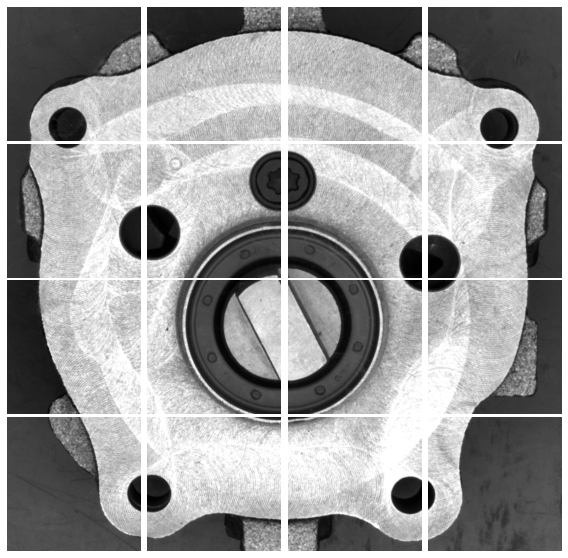

In [16]:
plt.figure(figsize=(10, 10))
for part in X_anomaly[1]:
    plt.subplot(4, 4, (part[0]+1))
    plt.axis('off')
    plt.subplots_adjust(wspace=0.02, hspace=0.02)
    plt.imshow(part[1], cmap='gray')

## Train e validation set

In [17]:
X_train, X__train_val = train_test_split(np.expand_dims(np.array(X_train), -1), test_size=0.2, random_state=17)
X_noisy, X__noisy_val = train_test_split(np.expand_dims(np.array(X_noisy), -1), test_size=0.2, random_state=17)

# Autoencoder

### Diverse architeture di autoencoder

Autoencoder con fully connected

In [18]:
img_shape = X_train.shape[1:]
input_img = Input(img_shape)

#encoded = Dense(1, activation='relu')
encoded = Flatten()(input_img)
encoded = Dense(256, activation='relu')(encoded)
encoded = Dense(128, activation='relu')(encoded)

decoded = Dense(256, activation='relu')(encoded)
decoded = Dense(np.prod(img_shape))(decoded)
decoded = Reshape((img_shape))(decoded)

In [19]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adamax', loss='mse')

In [20]:
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               16777472  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 65536)             16842752  
_________________________________________________________________
reshape (Reshape)            (None, 256, 256, 1)      

In [22]:
#add early stopping
custom_early_stopping = EarlyStopping(monitor='val_loss', patience=20, min_delta=0.0001, mode='min')

#random seed 
tf.random.set_seed(7)

hist=autoencoder.fit(X_noisy, X_train, epochs=300, batch_size=16, shuffle=True,
                     validation_data=(X__noisy_val, X__train_val), callbacks=[custom_early_stopping])

Epoch 1/300
75/75 [==============================] - 19s 249ms/step - loss: 0.0855 - val_loss: 0.0369
Epoch 2/300
75/75 [==============================] - 17s 230ms/step - loss: 0.0271 - val_loss: 0.0185
Epoch 3/300
75/75 [==============================] - 17s 224ms/step - loss: 0.0146 - val_loss: 0.0103
Epoch 4/300
75/75 [==============================] - 17s 221ms/step - loss: 0.0089 - val_loss: 0.0072
Epoch 5/300
75/75 [==============================] - 17s 226ms/step - loss: 0.0067 - val_loss: 0.0058
Epoch 6/300
75/75 [==============================] - 18s 241ms/step - loss: 0.0058 - val_loss: 0.0054
Epoch 7/300
75/75 [==============================] - 18s 236ms/step - loss: 0.0051 - val_loss: 0.0048
Epoch 8/300
75/75 [==============================] - 17s 227ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 9/300
75/75 [==============================] - 17s 227ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 10/300
75/75 [==============================] - 17s 225ms/step - loss: 0.003

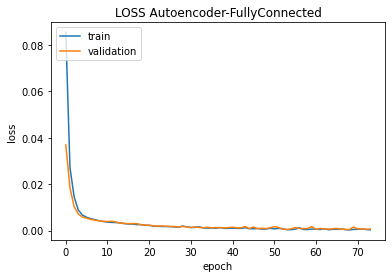

In [23]:
plot_hist(hist, 'Autoencoder-FullyConnected')

### Sample with spot artificially producted

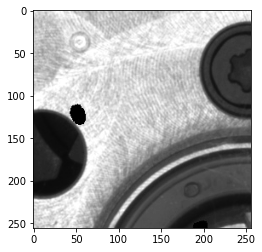

In [35]:
plt.imshow(np.squeeze(X_noisy[10],-1), cmap='gray')

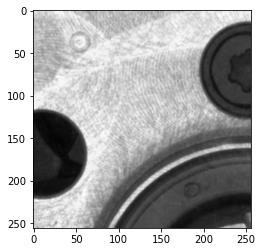

In [36]:
test_artificial = autoencoder.predict(np.expand_dims(X_noisy[10],0))
plt.imshow(np.squeeze(test_artificial[0], -1), cmap='gray')

### Saving model 

In [37]:
autoencoder.save("../Models/autoencoderFC")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../Models/autoencoderFC\assets
